In [1]:
!pip install pymongo

You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import json
import boto3
import numpy as np
import pandas as pd
from bson import json_util

In [3]:
client = boto3.client('s3')

In [4]:
train = pd.read_csv('s3:nlp-kc-learning/train.csv', names=["Label", "Title", "Review"])

In [5]:
train1 = train[train.Label==1]

In [6]:
train2 = train1['Review']

In [16]:
train3 = train2.tolist()

In [7]:
test = pd.read_csv('s3:nlp-kc-learning/test.csv', names=["Label", "Title", "Review"])

In [32]:
test1 = test.Review[test.Label==1]

In [34]:
test2=test1.tolist()

In [159]:
test2a.head(20)

,Label,Title,Review
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
5,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...
6,1,Incorrect Disc,"I love the style of this, but after a couple y..."
7,1,DVD menu select problems,I cannot scroll through a DVD menu that is set...
9,1,"Not an ""ultimate guide""","Firstly,I enjoyed the format and tone of the b..."
11,1,Not!,"If you want to listen to El Duke , then it is ..."
12,1,A complete Bust,This game requires quicktime 5.0 to work...if ...
14,1,didn't run off of USB bus power,Was hoping that this drive would run off of bu...
15,1,Don't buy!,"First of all, the company took my money and se..."
20,1,Long and boring,"I've read this book with much expectation, it ..."


In [8]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'ntm')

In [9]:
import sagemaker
sess = sagemaker.Session()

In [10]:
import os
from sagemaker import get_execution_role

role = get_execution_role()

In [11]:
bucket = 'nlp-kc-learning'
prefix = 'moss'

val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Validation set location s3://nlp-kc-learning/moss/val
Trained model will be saved at s3://nlp-kc-learning/moss/output


In [12]:
train2.to_csv("train_neg.csv", encoding="utf-8")

In [13]:
from io import StringIO
bucket = 'nlp-kc-learning'
csv_buffer=StringIO()
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'train_neg.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '956526727A76863D',
  'HostId': '1lQyJMhfiP4sxMEhxObnzgvPG+ngeDjv47DnLn3J6fcnG/sv3z2IZIA+mVRfUKw5zc+DBFmZGy8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '1lQyJMhfiP4sxMEhxObnzgvPG+ngeDjv47DnLn3J6fcnG/sv3z2IZIA+mVRfUKw5zc+DBFmZGy8=',
   'x-amz-request-id': '956526727A76863D',
   'date': 'Thu, 25 Apr 2019 15:44:05 GMT',
   'etag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"'}

### Comprehend experience

In [ ]:
comprehend = boto3.client('comprehend')

In [ ]:
sentiment = comprehend.start_topics_detection_job(InputDataConfig=str(train.Review.values))
#detect_sentiment(Text=str(sample.content.values), LanguageCode='en')
print(sentiment)

In [ ]:
input_s3_url = "s3://nlp-kc-learning/train_neg.csv"
input_doc_format = "ONE_DOC_PER_LINE"
output_s3_url = "s3://nlp-kc-learning/moss/"
data_access_role_arn = "arn:aws:iam::023375022819:role/service-role/AmazonComprehendServiceRole-mark"
number_of_topics = 10

input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}
output_data_config = {"S3Uri": output_s3_url}

start_topics_detection_job_result = \
    comprehend.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                          JobName="moss_topics_detection",
                                          InputDataConfig=input_data_config,
                                          OutputDataConfig=output_data_config,
                                          DataAccessRoleArn=data_access_role_arn)

print('start_topics_detection_job_result: ' + json.dumps(start_topics_detection_job_result))
 
job_id = start_topics_detection_job_result["JobId"]
 
print('job_id: ' + job_id)
print('\n\n\n')
 
describe_topics_detection_job_result = comprehend.describe_topics_detection_job(JobId=job_id)
 
print('describe_topics_detection_job_result: ' + json.dumps(describe_topics_detection_job_result, default=json_util.default))
print('\n\n\n')

list_topics_detection_jobs_result = comprehend.list_topics_detection_jobs()
 
print('list_topics_detection_jobs_result: ' + json.dumps(list_topics_detection_jobs_result, default=json_util.default))
print('\n\n\n')

In [ ]:
list_topics_detection_jobs_result.items

## -------------------------

In [14]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',
                             tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)

Tokenizing and counting, this may take a few minutes...


In [17]:
## training set
vectors = vectorizer.fit_transform(train3)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

vocab size: 2000
Done. Time elapsed: 1871.16s


In [18]:
# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

In [19]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


In [35]:
## test set
vectors1 = vectorizer.fit_transform(test2)
vocab_list1 = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list1))

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

vocab size: 2000
Done. Time elapsed: 2275.61s


In [36]:
vectors1.shape[0]

200000

In [39]:
vectors_tst = sparse.csr_matrix(vectors1, dtype=np.float32)
print(type(vectors_tst), vectors_tst.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


In [20]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [21]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(1440000, 2000) (180000, 2000) (180000, 2000)


In [22]:
import os
from sagemaker import get_execution_role

role = get_execution_role()

In [23]:
bucket = 'nlp-kc-learning'
prefix = 'moss'

In [24]:
train_prefix = os.path.join(prefix, 'train')

s3_train_data = os.path.join('s3://', bucket, train_prefix)

print('Training set location', s3_train_data)


Training set location s3://nlp-kc-learning/moss/train
Validation set location s3://nlp-kc-learning/moss/val
Trained model will be saved at s3://nlp-kc-learning/moss/output


In [40]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [41]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://nlp-kc-learning/moss/train/train_part0.pbr
Uploaded data to s3://nlp-kc-learning/moss/train/train_part1.pbr
Uploaded data to s3://nlp-kc-learning/moss/train/train_part2.pbr
Uploaded data to s3://nlp-kc-learning/moss/train/train_part3.pbr
Uploaded data to s3://nlp-kc-learning/moss/train/train_part4.pbr
Uploaded data to s3://nlp-kc-learning/moss/train/train_part5.pbr
Uploaded data to s3://nlp-kc-learning/moss/train/train_part6.pbr
Uploaded data to s3://nlp-kc-learning/moss/train/train_part7.pbr
Uploaded data to s3://nlp-kc-learning/moss/val/val_part0.pbr


In [42]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'ntm')

In [43]:
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name= 'aaronmossjob',
                                    train_instance_count=3, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

In [44]:
num_topics = 10
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocab_size, mini_batch_size=128, 
                        epochs=25, num_patience_epochs=5, tolerance=0.001)

In [45]:
from sagemaker.session import s3_input
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key') 

In [46]:
ntm.fit({'train': s3_train, 'validation': s3_val_data})

INFO:sagemaker:Creating training-job with name: aaronmossjob-2019-04-25-16-30-31-576


2019-04-25 16:30:31 Starting - Starting the training job...
2019-04-25 16:30:33 Starting - Launching requested ML instances......
2019-04-25 16:31:45 Starting - Preparing the instances for training.........
2019-04-25 16:33:24 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[04/25/2019 16:33:45 INFO 140590214039360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'sub_sample': u'1.0', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'tolerance': u'0.001', u'batch_norm': u'fal


2019-04-25 16:33:46 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[04/25/2019 16:33:48 INFO 139904211511104] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'sub_sample': u'1.0', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'tolerance': u'0.001', u'batch_norm': u'false'}
[04/25/2019 16:33:48 INFO 139904211511104] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'num_patience_epochs': u'5', u'num_topics': u'10', u'epochs': u'25', u'feature_dim': u'2000', u'mi

[04/25/2019 16:35:18 INFO 140590214039360] # Finished training epoch 1 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:35:18 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:35:18 INFO 140590214039360] Loss (name: value) total: 6.66461337092
[04/25/2019 16:35:18 INFO 140590214039360] Loss (name: value) kld: 0.0756919756483
[04/25/2019 16:35:18 INFO 140590214039360] Loss (name: value) recons: 6.58892139717
[04/25/2019 16:35:18 INFO 140590214039360] Loss (name: value) logppx: 6.66461337092
[04/25/2019 16:35:18 INFO 140590214039360] #quality_metric: host=algo-3, epoch=1, train total_loss <loss>=6.66461337092
[2019-04-25 16:35:18.954] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 0, "duration": 93190, "num_examples": 1}
[04/25/2019 16:35:30 INFO 140590214039360] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:35:30 INFO 140590214039360] Metrics for Inference:
[04/25/2019 16:3

[04/25/2019 16:36:57 INFO 140590214039360] # Finished training epoch 2 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:36:57 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:36:57 INFO 140590214039360] Loss (name: value) total: 6.54893315436
[04/25/2019 16:36:57 INFO 140590214039360] Loss (name: value) kld: 0.157861502464
[04/25/2019 16:36:57 INFO 140590214039360] Loss (name: value) recons: 6.39107165242
[04/25/2019 16:36:57 INFO 140590214039360] Loss (name: value) logppx: 6.54893315436
[04/25/2019 16:36:57 INFO 140590214039360] #quality_metric: host=algo-3, epoch=2, train total_loss <loss>=6.54893315436
[2019-04-25 16:36:57.745] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 1, "duration": 98790, "num_examples": 1407}
[04/25/2019 16:37:09 INFO 140590214039360] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:37:09 INFO 140590214039360] Metrics for Inference:
[04/25/2019 16

[04/25/2019 16:40:15 INFO 140590214039360] # Finished training epoch 4 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:40:15 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:40:15 INFO 140590214039360] Loss (name: value) total: 6.52853242113
[04/25/2019 16:40:15 INFO 140590214039360] Loss (name: value) kld: 0.187616210604
[04/25/2019 16:40:15 INFO 140590214039360] Loss (name: value) recons: 6.34091620957
[04/25/2019 16:40:15 INFO 140590214039360] Loss (name: value) logppx: 6.52853242113
[04/25/2019 16:40:15 INFO 140590214039360] #quality_metric: host=algo-3, epoch=4, train total_loss <loss>=6.52853242113
[2019-04-25 16:40:15.445] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 3, "duration": 97710, "num_examples": 1407}
[04/25/2019 16:40:27 INFO 140590214039360] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:40:27 INFO 140590214039360] Metrics for Inference:
[04/25/2019 16

[04/25/2019 16:43:38 INFO 140590214039360] # Finished training epoch 6 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:43:38 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:43:38 INFO 140590214039360] Loss (name: value) total: 6.52607285353
[04/25/2019 16:43:38 INFO 140590214039360] Loss (name: value) kld: 0.191044585792
[04/25/2019 16:43:38 INFO 140590214039360] Loss (name: value) recons: 6.33502826545
[04/25/2019 16:43:38 INFO 140590214039360] Loss (name: value) logppx: 6.52607285353
[04/25/2019 16:43:38 INFO 140590214039360] #quality_metric: host=algo-3, epoch=6, train total_loss <loss>=6.52607285353
[2019-04-25 16:43:38.425] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 5, "duration": 100131, "num_examples": 1407}
[04/25/2019 16:43:50 INFO 140590214039360] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:43:50 INFO 140590214039360] Metrics for Inference:
[04/25/2019 1

[04/25/2019 16:45:13 INFO 140590214039360] # Finished training epoch 7 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:45:13 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:45:13 INFO 140590214039360] Loss (name: value) total: 6.51912659629
[04/25/2019 16:45:13 INFO 140590214039360] Loss (name: value) kld: 0.200189670284
[04/25/2019 16:45:13 INFO 140590214039360] Loss (name: value) recons: 6.31893692235
[04/25/2019 16:45:13 INFO 140590214039360] Loss (name: value) logppx: 6.51912659629
[04/25/2019 16:45:13 INFO 140590214039360] #quality_metric: host=algo-3, epoch=7, train total_loss <loss>=6.51912659629
[2019-04-25 16:45:13.655] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 6, "duration": 95230, "num_examples": 1407}
[04/25/2019 16:45:25 INFO 140590214039360] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:45:25 INFO 140590214039360] Metrics for Inference:
[04/25/2019 16

[04/25/2019 16:47:29 INFO 139933765801792] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:47:29 INFO 139933765801792] Metrics for Inference:
[04/25/2019 16:47:29 INFO 139933765801792] Loss (name: value) total: 6.51310268846
[04/25/2019 16:47:29 INFO 139933765801792] Loss (name: value) kld: 0.209255355107
[04/25/2019 16:47:29 INFO 139933765801792] Loss (name: value) recons: 6.30384732649
[04/25/2019 16:47:29 INFO 139933765801792] Loss (name: value) logppx: 6.51310268846
[04/25/2019 16:47:29 INFO 139933765801792] #validation_score (5): 6.51310268846
[04/25/2019 16:47:29 INFO 139933765801792] Timing: train: 147.45s, val: 15.89s, epoch: 163.34s
[04/25/2019 16:47:29 INFO 139933765801792] #progress_metric: host=algo-1, completed 20 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 4219, "sum": 4219.0, "min": 4219}, "Number of Batches Since Last Reset": {"count": 1, "max": 4219, "sum": 4219.0, "min": 4219}, "Numbe

[04/25/2019 16:50:12 INFO 140590214039360] # Finished training epoch 10 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:50:12 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:50:12 INFO 140590214039360] Loss (name: value) total: 6.51677309971
[04/25/2019 16:50:12 INFO 140590214039360] Loss (name: value) kld: 0.207705555704
[04/25/2019 16:50:12 INFO 140590214039360] Loss (name: value) recons: 6.30906753806
[04/25/2019 16:50:12 INFO 140590214039360] Loss (name: value) logppx: 6.51677309971
[04/25/2019 16:50:12 INFO 140590214039360] #quality_metric: host=algo-3, epoch=10, train total_loss <loss>=6.51677309971
[2019-04-25 16:50:12.849] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 9, "duration": 99475, "num_examples": 1407}
[04/25/2019 16:50:13 INFO 139933765801792] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:50:13 INFO 139933765801792] Metrics for Inference:
[04/25/2019 

[04/25/2019 16:51:54 INFO 140590214039360] # Finished training epoch 11 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:51:54 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:51:54 INFO 140590214039360] Loss (name: value) total: 6.5182072117
[04/25/2019 16:51:54 INFO 140590214039360] Loss (name: value) kld: 0.208104959447
[04/25/2019 16:51:54 INFO 140590214039360] Loss (name: value) recons: 6.31010225105
[04/25/2019 16:51:54 INFO 140590214039360] Loss (name: value) logppx: 6.5182072117
[04/25/2019 16:51:54 INFO 140590214039360] #quality_metric: host=algo-3, epoch=11, train total_loss <loss>=6.5182072117
[2019-04-25 16:51:54.165] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 10, "duration": 101315, "num_examples": 1407}
[04/25/2019 16:52:06 INFO 140590214039360] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:52:06 INFO 140590214039360] Metrics for Inference:
[04/25/2019 1

[04/25/2019 16:53:34 INFO 140590214039360] # Finished training epoch 12 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:53:34 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:53:34 INFO 140590214039360] Loss (name: value) total: 6.51599918758
[04/25/2019 16:53:34 INFO 140590214039360] Loss (name: value) kld: 0.209243660555
[04/25/2019 16:53:34 INFO 140590214039360] Loss (name: value) recons: 6.30675552089
[04/25/2019 16:53:34 INFO 140590214039360] Loss (name: value) logppx: 6.51599918758
[04/25/2019 16:53:34 INFO 140590214039360] #quality_metric: host=algo-3, epoch=12, train total_loss <loss>=6.51599918758
[2019-04-25 16:53:34.917] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 11, "duration": 100751, "num_examples": 1407}
[04/25/2019 16:53:46 INFO 140590214039360] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:53:46 INFO 140590214039360] Metrics for Inference:
[04/25/201

[04/25/2019 16:55:48 INFO 139904211511104] # Finished training epoch 8 on 540000 examples from 4219 batches, each of size 128.
[04/25/2019 16:55:48 INFO 139904211511104] Metrics for Training:
[04/25/2019 16:55:48 INFO 139904211511104] Loss (name: value) total: 6.51861211219
[04/25/2019 16:55:48 INFO 139904211511104] Loss (name: value) kld: 0.209564624161
[04/25/2019 16:55:48 INFO 139904211511104] Loss (name: value) recons: 6.30904748582
[04/25/2019 16:55:48 INFO 139904211511104] Loss (name: value) logppx: 6.51861211219
[04/25/2019 16:55:48 INFO 139904211511104] #quality_metric: host=algo-2, epoch=8, train total_loss <loss>=6.51861211219
[2019-04-25 16:55:48.404] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 7, "duration": 166539, "num_examples": 1407}
[04/25/2019 16:56:04 INFO 139904211511104] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 16:56:04 INFO 139904211511104] Metrics for Inference:
[04/25/2019 1

[04/25/2019 16:58:31 INFO 140590214039360] # Finished training epoch 15 on 360000 examples from 2813 batches, each of size 128.
[04/25/2019 16:58:31 INFO 140590214039360] Metrics for Training:
[04/25/2019 16:58:31 INFO 140590214039360] Loss (name: value) total: 6.51687300226
[04/25/2019 16:58:31 INFO 140590214039360] Loss (name: value) kld: 0.20893855224
[04/25/2019 16:58:31 INFO 140590214039360] Loss (name: value) recons: 6.3079344516
[04/25/2019 16:58:31 INFO 140590214039360] Loss (name: value) logppx: 6.51687300226
[04/25/2019 16:58:31 INFO 140590214039360] #quality_metric: host=algo-3, epoch=15, train total_loss <loss>=6.51687300226
[2019-04-25 16:58:31.725] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 14, "duration": 96299, "num_examples": 1407}
[04/25/2019 16:58:33 INFO 139904211511104] # Finished training epoch 9 on 540000 examples from 4219 batches, each of size 128.
[04/25/2019 16:58:33 INFO 139904211511104] Metrics for Training:
[04

[04/25/2019 17:00:41 INFO 139933765801792] # Finished training epoch 10 on 540000 examples from 4219 batches, each of size 128.
[04/25/2019 17:00:41 INFO 139933765801792] Metrics for Training:
[04/25/2019 17:00:41 INFO 139933765801792] Loss (name: value) total: 6.51582853284
[04/25/2019 17:00:41 INFO 139933765801792] Loss (name: value) kld: 0.2091993313
[04/25/2019 17:00:41 INFO 139933765801792] Loss (name: value) recons: 6.30662920374
[04/25/2019 17:00:41 INFO 139933765801792] Loss (name: value) logppx: 6.51582853284
[04/25/2019 17:00:41 INFO 139933765801792] #quality_metric: host=algo-1, epoch=10, train total_loss <loss>=6.51582853284
[2019-04-25 17:00:41.382] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 9, "duration": 157369, "num_examples": 1407}
[04/25/2019 17:00:56 INFO 139933765801792] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 17:00:56 INFO 139933765801792] Metrics for Inference:
[04/25/2019 1

[04/25/2019 17:03:39 INFO 139904211511104] # Finished training epoch 11 on 540000 examples from 4219 batches, each of size 128.
[04/25/2019 17:03:39 INFO 139904211511104] Metrics for Training:
[04/25/2019 17:03:39 INFO 139904211511104] Loss (name: value) total: 6.5135724058
[04/25/2019 17:03:39 INFO 139904211511104] Loss (name: value) kld: 0.211448285924
[04/25/2019 17:03:39 INFO 139904211511104] Loss (name: value) recons: 6.30212411487
[04/25/2019 17:03:39 INFO 139904211511104] Loss (name: value) logppx: 6.5135724058
[04/25/2019 17:03:39 INFO 139904211511104] #quality_metric: host=algo-2, epoch=11, train total_loss <loss>=6.5135724058
[2019-04-25 17:03:39.852] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 10, "duration": 147780, "num_examples": 1407}
[04/25/2019 17:03:54 INFO 139904211511104] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 17:03:54 INFO 139904211511104] Metrics for Inference:
[04/25/2019 1

[04/25/2019 17:09:04 INFO 139933765801792] # Finished training epoch 14 on 540000 examples from 4219 batches, each of size 128.
[04/25/2019 17:09:04 INFO 139933765801792] Metrics for Training:
[04/25/2019 17:09:04 INFO 139933765801792] Loss (name: value) total: 6.51065680336
[04/25/2019 17:09:04 INFO 139933765801792] Loss (name: value) kld: 0.212145554808
[04/25/2019 17:09:04 INFO 139933765801792] Loss (name: value) recons: 6.29851125015
[04/25/2019 17:09:04 INFO 139933765801792] Loss (name: value) logppx: 6.51065680336
[04/25/2019 17:09:04 INFO 139933765801792] #quality_metric: host=algo-1, epoch=14, train total_loss <loss>=6.51065680336
[2019-04-25 17:09:04.336] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 13, "duration": 114457, "num_examples": 1407}
[04/25/2019 17:09:14 INFO 139933765801792] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 17:09:14 INFO 139933765801792] Metrics for Inference:
[04/25/201

[04/25/2019 17:14:54 INFO 139933765801792] # Finished training epoch 17 on 540000 examples from 4219 batches, each of size 128.
[04/25/2019 17:14:54 INFO 139933765801792] Metrics for Training:
[04/25/2019 17:14:54 INFO 139933765801792] Loss (name: value) total: 6.51077189754
[04/25/2019 17:14:54 INFO 139933765801792] Loss (name: value) kld: 0.21335203692
[04/25/2019 17:14:54 INFO 139933765801792] Loss (name: value) recons: 6.29741986495
[04/25/2019 17:14:54 INFO 139933765801792] Loss (name: value) logppx: 6.51077189754
[04/25/2019 17:14:54 INFO 139933765801792] #quality_metric: host=algo-1, epoch=17, train total_loss <loss>=6.51077189754
[2019-04-25 17:14:54.097] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 16, "duration": 117832, "num_examples": 1407}
[04/25/2019 17:15:03 INFO 139933765801792] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 17:15:03 INFO 139933765801792] Metrics for Inference:
[04/25/2019

[04/25/2019 17:20:44 INFO 139933765801792] # Finished training epoch 20 on 540000 examples from 4219 batches, each of size 128.
[04/25/2019 17:20:44 INFO 139933765801792] Metrics for Training:
[04/25/2019 17:20:44 INFO 139933765801792] Loss (name: value) total: 6.50910460483
[04/25/2019 17:20:44 INFO 139933765801792] Loss (name: value) kld: 0.219079769549
[04/25/2019 17:20:44 INFO 139933765801792] Loss (name: value) recons: 6.290024833
[04/25/2019 17:20:44 INFO 139933765801792] Loss (name: value) logppx: 6.50910460483
[04/25/2019 17:20:44 INFO 139933765801792] #quality_metric: host=algo-1, epoch=20, train total_loss <loss>=6.50910460483
[2019-04-25 17:20:44.999] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 19, "duration": 114982, "num_examples": 1407}
[04/25/2019 17:20:55 INFO 139933765801792] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 17:20:55 INFO 139933765801792] Metrics for Inference:
[04/25/2019 

[04/25/2019 17:26:32 INFO 139933765801792] # Finished training epoch 23 on 540000 examples from 4219 batches, each of size 128.
[04/25/2019 17:26:32 INFO 139933765801792] Metrics for Training:
[04/25/2019 17:26:32 INFO 139933765801792] Loss (name: value) total: 6.50571492081
[04/25/2019 17:26:32 INFO 139933765801792] Loss (name: value) kld: 0.22825256429
[04/25/2019 17:26:32 INFO 139933765801792] Loss (name: value) recons: 6.27746235643
[04/25/2019 17:26:32 INFO 139933765801792] Loss (name: value) logppx: 6.50571492081
[04/25/2019 17:26:32 INFO 139933765801792] #quality_metric: host=algo-1, epoch=23, train total_loss <loss>=6.50571492081
[2019-04-25 17:26:32.485] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 22, "duration": 116096, "num_examples": 1407}
[04/25/2019 17:26:42 INFO 139933765801792] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 17:26:42 INFO 139933765801792] Metrics for Inference:
[04/25/2019


2019-04-25 17:30:59 Uploading - Uploading generated training model
2019-04-25 17:30:59 Completed - Training job completed
[04/25/2019 17:30:46 INFO 139904211511104] Finished scoring on 179968 examples from 1406 batches, each of size 128.
[04/25/2019 17:30:46 INFO 139904211511104] Metrics for Inference:
[04/25/2019 17:30:46 INFO 139904211511104] Loss (name: value) total: 6.51353128197
[04/25/2019 17:30:46 INFO 139904211511104] Loss (name: value) kld: 0.207419769587
[04/25/2019 17:30:46 INFO 139904211511104] Loss (name: value) recons: 6.30611151347
[04/25/2019 17:30:46 INFO 139904211511104] Loss (name: value) logppx: 6.51353128197
[04/25/2019 17:30:46 INFO 139904211511104] #quality_metric: host=algo-2, epoch=11, validation total_loss <loss>=6.51353128197
[04/25/2019 17:30:46 INFO 139904211511104] Loss of server-side model: 6.51353128197
[04/25/2019 17:30:46 INFO 139904211511104] Best model based on early stopping at epoch 5. Best loss: 6.51043439861
[04/25/2019 17:30:46 INFO 13990421151

Billable seconds: 10364


In [47]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: aaronmossjob-2019-04-25-16-30-31-576


In [48]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: ntm-2019-04-25-17-32-58-096
INFO:sagemaker:Creating endpoint with name aaronmossjob-2019-04-25-16-30-31-576


----------------------------------------------------------------------------------------------------!

In [49]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint))

Endpoint name: aaronmossjob-2019-04-25-16-30-31-576


In [ ]:
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

In [57]:
from sagemaker.predictor import csv_serializer, json_deserializer

ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer

In [ ]:
test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:5])
print(results)

In [53]:
test_data_full = np.array(vectors_tst.todense())

In [56]:
results_full = ntm_predictor.predict(vectors1[:10000])

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [71]:
# full test data
test_data_full = np.array(vectors_tst.todense())

In [131]:
results_full = ntm_predictor.predict(test_data_full[:10])

In [132]:
print(results_full)

{'predictions': [{'topic_weights': [0.1165521964, 0.0913761482, 0.0975406617, 0.0643444285, 0.2140946388, 0.0942866355, 0.0947133526, 0.1093520969, 0.0648432449, 0.052896671]}, {'topic_weights': [0.1189275458, 0.0935707539, 0.0703211725, 0.2002211511, 0.0705644712, 0.0716817304, 0.0696063042, 0.076000385, 0.0924226642, 0.1366838068]}, {'topic_weights': [0.3914327025, 0.0630526543, 0.0668352917, 0.0873404592, 0.0638733879, 0.0651632771, 0.0634139106, 0.0618334673, 0.0648173913, 0.0722375512]}, {'topic_weights': [0.1124764383, 0.068726182, 0.0732384324, 0.0970809534, 0.0599014089, 0.0714360029, 0.0711140931, 0.2476294488, 0.0747735947, 0.1236234605]}, {'topic_weights': [0.1439232677, 0.0523980334, 0.0655551329, 0.2273790985, 0.0502465479, 0.0642922372, 0.0624970198, 0.2140279114, 0.0615230426, 0.058157824]}, {'topic_weights': [0.2086798102, 0.0723338425, 0.0717713162, 0.1732192039, 0.0695170686, 0.0707703605, 0.0698544383, 0.0568669848, 0.074523747, 0.1324631423]}, {'topic_weights': [0.3

In [133]:
pred_test = np.array([prediction['topic_weights'] for prediction in results_full['predictions']])

In [ ]:
results

In [113]:
test1a = test[test.Label==1]

In [115]:
test2a =test1a[:600]

In [ ]:
test

In [121]:
pred_test.shape

(600, 10)

In [125]:
print (pred_test)

[[0.1165522  0.09137615 0.09754066 ... 0.1093521  0.06484324 0.05289667]
 [0.11892755 0.09357075 0.07032117 ... 0.07600039 0.09242268 0.13668381]
 [0.3914327  0.06305265 0.06683528 ... 0.06183347 0.06481739 0.07223755]
 ...
 [0.07170653 0.15261699 0.0713416  ... 0.0837216  0.07213472 0.18956518]
 [0.07909842 0.0752635  0.0783104  ... 0.12010554 0.10210624 0.06920021]
 [0.06447116 0.07433524 0.12615666 ... 0.16472414 0.06525113 0.07349328]]


Text(0.5,0,'Topic ID')

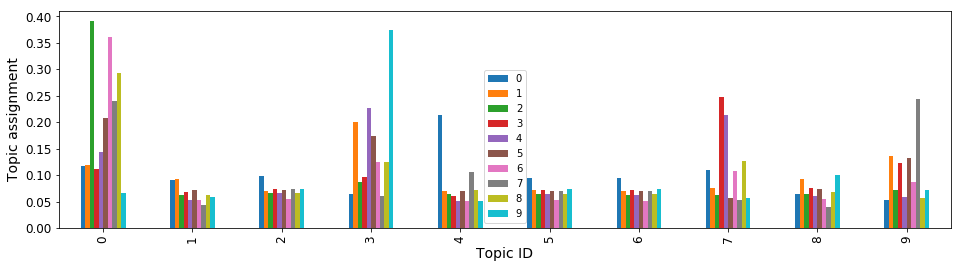

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(pred_test.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

In [158]:
vocab_list1[:10]

['ability',
 'able',
 'absolute',
 'absolutely',
 'abuse',
 'accept',
 'acceptable',
 'access',
 'according',
 'account']

Stop / Close the Endpoint
Finally, we should delete the endpoint before we close the notebook.

To restart the endpoint you can follow the code above using the same endpoint_name we created or you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [ ]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint)

In [ ]:
# If you use conda_mxnet_p36 kernel, mxnet is already installed, otherwise, uncomment the following line to install.
# !pip install mxnet 
import mxnet as mx

In [ ]:
model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
model_path

In [ ]:
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [ ]:
!tar -xzvf 'downloaded_model.tar.gz'

In [ ]:
# use flag -o to overwrite previous unzipped content
!unzip -o model_algo-1

In [ ]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

In [ ]:
!pip install wordcloud
import wordcloud as wc

In [ ]:
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1